# *PR-2 Image_Segmentation*

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
from os import listdir
from multiprocessing import Pool
import numba
import numpy as np
from random import randint
from scipy.io import loadmat
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import v_measure_score
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from copy import deepcopy
import cProfile
from multiprocessing.pool import ThreadPool
import cupy as cp

In [ ]:
!curl https://colab.chainer.org/install | sh -

!pip install cucim
!pip install scipy scikit-image cupy-cuda100

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   5724      0 --:--:-- --:--:-- --:--:--  5724
********************************************************************************
GPU is not enabled!
Open "Runtime" > "Change runtime type" and set "Hardware accelerator" to "GPU".
********************************************************************************
     |████████████████████████████████| 8.3 MB 8.2 MB/s 
     |████████████████████████████████| 58.9 MB 1.3 MB/s 


Mount data from google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def coloring_image(lables, original_image, k):
  colors = [[randint(0,225), randint(0,225), randint(0,225)] for _ in range(k)]
  colored_image = [colors[lables[i]] for i in range(lables.shape[0])]
  return np.asarray(colored_image)

In [ ]:
def K_Means(X, n_clusters, max_iters=300, tol=10**(-4), verbose=False): 
  n_samples = X.shape[0]
  n_features = X.shape[1]

  X = cp.asarray(X)

  mean = cp.mean(X, axis=0)
  variance = cp.std(X, axis=0)

  centers = cp.random.randn(n_clusters, n_features) * cp.array(variance) + cp.array(mean)
  clusters = cp.zeros(n_samples)
  distances = cp.zeros((n_samples, n_clusters))

  error = cp.linalg.norm(centers)
  i = 1
  while error > tol and i < max_iters:       #means that the centers remain the same
    for k in range(n_clusters):
      if verbose:
        print("distance between clusters and center (", i, ") are calculated....")
      distances[:, k] = cp.linalg.norm(X - centers[k], axis=1)  #axis=0 "row"
    if verbose:
      print(".................................................................................")

    clusters = cp.argmin(distances, axis=1)
    old_centers = centers
    centers = cp.asarray([cp.mean(X[clusters == k], axis=0) for k in range(n_clusters)])
    error = cp.linalg.norm(centers - old_centers)
    i += 1
  
  return cp.asnumpy(centers), cp.asnumpy(clusters)


In [ ]:
def predict_labels(algorithm, X, k, tol, max_iters):
  if algorithm == 'kmeans':
    _ , labels_ = K_Means(X , k, tol=tol, max_iters=max_iters)
    return labels_
  # if algorithm == 'knn':
    
    # return graph.cut_normalized(labels, rag)

In [ ]:
def segment_image_and_evaluate(visualize=False,
                               verbose=False,
                               train_images_count=50,
                               pixels_count=154401, 
                               K=range(3, 13, 2),
                               classifier='kmeans',
                               tol=10 **(-4),
                               max_iters=300):
  
  imgs_root = '/content/drive/MyDrive/BSR/BSDS500/data/images/test/'
  labels_root = '/content/drive/MyDrive/BSR/BSDS500/data/groundTruth/test/'

  k_values_count = len(K)

  overall_f1_score, overall_entopy_score = np.zeros(k_values_count), np.zeros(k_values_count)
  for img_name in listdir(imgs_root)[:train_images_count]:
    '''
    get image name w/o extension .jpg and compare it w/ ground truth file name
    then return the ground truth object `['groundTruth']`
    '''
    img_gnd_truth = loadmat(labels_root +\
                            img_name[:len(img_name)-len('.jpg')] +\
                            '.mat')['groundTruth']

    img = Image.open(imgs_root + img_name)
    img_mat = np.array(img).reshape(481, 321, 3)
    img_arr = img_mat.reshape(pixels_count, 3)
    
    if visualize:
      plt.imshow(img_mat)
      plt.figure()

    for k in K:
      
      pred_labels = predict_labels(classifier, img_arr, k, tol, max_iters)

      if visualize:
        plt.imshow(coloring_image(pred_labels, img_arr, k).reshape(481, 321, 3))
        plt.figure()
  
      img_f1_acc_score, img_entropy_acc_score = 0, 0
      for m in range(img_gnd_truth.shape[1]):
        true_labels = np.array(img_gnd_truth[0][m][0][0][0]).ravel()

        img_f1_gnd_m_score = f1_score(true_labels,
                                      pred_labels,
                                      average='macro')

        img_entropy_gnd_m_score = v_measure_score(true_labels,        
                                                  pred_labels)

        if verbose:
          print("img_no. =", img_name,
                "\tK =", k,
                "\tground truth =", m,
                "\tF1 score =", img_f1_gnd_m_score,
                "\tConditional Entropy score =", img_entropy_gnd_m_score)
          print('...........................................')

        img_f1_acc_score += img_f1_gnd_m_score
        img_entropy_acc_score += img_entropy_gnd_m_score

      if verbose:
        print('_____________________________________________')

      img_f1_avg_score = img_f1_acc_score / img_gnd_truth.shape[1]
      img_entropy_avg_score = img_entropy_acc_score / img_gnd_truth.shape[1]

      if verbose:
        print("img_no. =", img_name,
                "\tAvg. F1 score =", img_f1_avg_score,
                "\tAvg. Conditional Entropy score =", img_entropy_avg_score)
        print('...........................................')
        print('...........................................')

      overall_f1_score[(k-3)//2] += img_f1_avg_score
      overall_entopy_score[(k-3)//2] += img_entropy_avg_score

    if verbose:
      print("################################################")

  overall_f1_score /= train_images_count
  overall_entopy_score /= train_images_count

  plt.plot(K, overall_f1_score)
  plt.title('F1 score vs K')
  plt.figure()

  plt.plot(K, overall_entopy_score)
  plt.title('Conditional Entropy score vs K')
  plt.show()

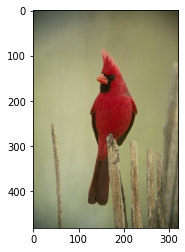

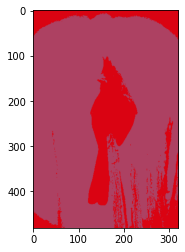

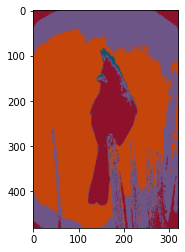

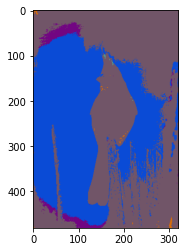

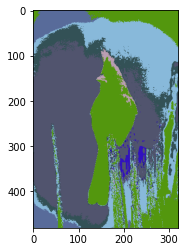

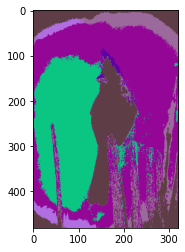

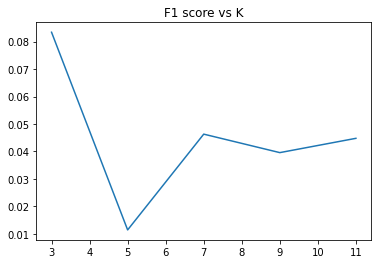

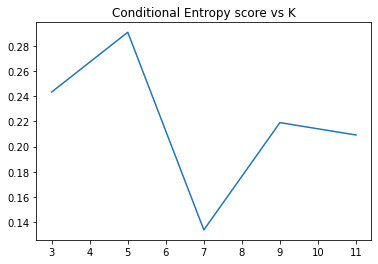

In [ ]:
segment_image_and_evaluate(train_images_count=1, visualize=True, tol=10 ** (-99999999999999999999999999999999999999), max_iters=99999999999999999999999999999999999999999999999999999999)

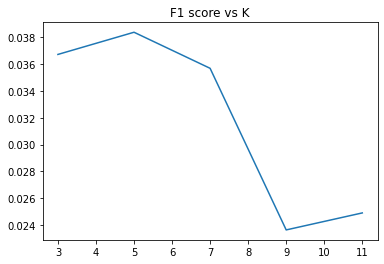

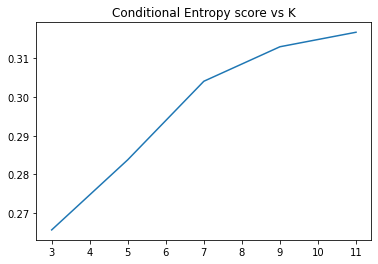

In [ ]:
segment_image_and_evaluate(train_images_count=50, tol=10 ** (-9999999999999999999999999999999999999999999999999999), max_iters=999999999999999999999999999999999999999999)